<h1> LSTM to generate Shakespearean Sonnet</h1>

This implemetation of LSTM is based on what I learnt from Udacity Deep Learning with PyTorch course. While in the course we generated text from Anna Karenina, here I have leveraged LSTM to generate sonnet based on Shakespeare's style. To achieve this we will train the LSTM model with Shakespeare's Sonnets, the model will eventually learn his style and will be able to predict the next character of the text with current character as input to the it. 

In [0]:
#importing required libraries 
import torch
from torch import nn
import numpy as np

<h2>Pre-processing Data</h2>

The file, <i>sonnets.txt</i>, contains all of 154 sonnets composed by Shakespeare. There are roughly 94k characters in the file for us to work with.

In [3]:
#importing data
with open("sonnets.txt","r") as sf:
  data = sf.read()
len(data)

93775

In [4]:
#checking data
print(data[:200])

From fairest creatures we desire increase,
That thereby beauty’s Rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou, contracted to thine own


In [0]:
#character dictionary
chars = tuple(set(data))
int_2_char = dict(enumerate(chars))
char_2_int = {ch:ii for ii,ch in int_2_char.items()}

#encoded characters
encoded = np.array([char_2_int[ch] for ch in data])

In [6]:
encoded[:100]

array([24,  8, 33, 27, 14, 47, 43, 61,  8, 13, 57, 32, 14, 19,  8, 13, 43,
       32,  9,  8, 13, 57, 14, 22, 13, 14, 23, 13, 57, 61,  8, 13, 14, 61,
       28, 19,  8, 13, 43, 57, 13, 40,  1, 37,  3, 43, 32, 14, 32,  3, 13,
        8, 13, 62, 15, 14, 62, 13, 43,  9, 32, 15, 49, 57, 14, 50, 33, 57,
       13, 14, 27, 61, 41,  3, 32, 14, 28, 13, 38, 13,  8, 14, 23, 61, 13,
       40,  1,  4,  9, 32, 14, 43, 57, 14, 32,  3, 13, 14,  8, 61])

In [0]:
def one_hot_encoding(array, n_labels):
  """method to one-hot encode characters  
  array: np.array to be encoded
  n_labels: no. of labels, size of dictionary"""
  
  #initialize encoded array 
  one_hot = np.zeros((np.multiply(*array.shape),n_labels),dtype = np.float32)
  
  #setting appropriate elements with ones
  one_hot[np.arange(one_hot.shape[0]),array.flatten()] = 1
  
  #reshape to required shape
  one_hot = one_hot.reshape((*array.shape,n_labels))
  
  return one_hot

In [8]:
#checking the method
one_hot_encoding(np.array([[3,5,6]]),8)

array([[[0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.]]], dtype=float32)

The model is trained using batches of the data. The following method generates a pair of array, <i>x</i>  and <i>y</i>. Where <i>x</i> is array of required characters and <i>y</i> is array of characters next to that corresponding to <i>x</i>. While sequences in <i>x</i> are used as features, sequences in <i>y</i> are used as labels for that of <i>x</i>. 

In [0]:
def get_batches(array, batch_size, seq_len):
  """method to generate batches of data
  array: one-hot encoded data as np.array
  batch_size: no. of sequences required in each batch
  seq_len: no. of characters in each sequence"""

  #calculating characters in each batch
  batch_size_total = batch_size * seq_len
  
  #no. of batches that can be genrated from the data
  n_batches = len(array) // batch_size_total
  
  array = array[:n_batches * batch_size_total]
  
  array = array.reshape((batch_size, -1))
  
  for n in range(0, array.shape[1], seq_len):
    
    x = array[:, n : n + seq_len]#batch of required characters as features
    y = np.zeros_like(x)#batch of coresponding x+1 character as labels
    
    try:
      y[:,:-1], y[:,-1] = x[:,1:], array[:,n+seq_len]
      
    except IndexError:
      y[:,:-1], y[:,-1] = x[:,1:], array[:,0]
      
    yield x,y

In [10]:
#testing get_batches()
for x,y in get_batches(encoded[:50],5,5):
  print("x =\n{}".format(x))
  print("Y =\n{}".format(y))

x =
[[24  8 33 27 14]
 [57 32 14 19  8]
 [13 57 14 22 13]
 [ 8 13 14 61 28]
 [13 40  1 37  3]]
Y =
[[ 8 33 27 14 47]
 [32 14 19  8 13]
 [57 14 22 13 14]
 [13 14 61 28 19]
 [40  1 37  3 43]]
x =
[[47 43 61  8 13]
 [13 43 32  9  8]
 [14 23 13 57 61]
 [19  8 13 43 57]
 [43 32 14 32  3]]
Y =
[[43 61  8 13 24]
 [43 32  9  8 57]
 [23 13 57 61 13]
 [ 8 13 43 57  8]
 [32 14 32  3 13]]


<h2>Building the model</h2>

In [11]:
#testing for gpu availibility
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [0]:
class CharLSTM(nn.Module):
  #class for the model
  
  def __init__(self, tokens_len, n_hidden=256, n_layers=2, drop_prob=0.5):
    
    super().__init__()
    
    self.chars_len = tokens_len#length of dictionary
    self.n_hidden = n_hidden#no. of hidden layers 
    self.n_layers = n_layers#no. of layers of LSTM cell
    self.drop_prob = drop_prob#dropout probability for regularization
    
    #LSTM layer of the model
    self.lstm = nn.LSTM(self.chars_len, self.n_hidden, self.n_layers, dropout=self.drop_prob, batch_first=True)
    
    #Dropout layer of the model
    self.dropout = nn.Dropout(self.drop_prob)
    
    #Fully connected layer of the model
    self.fc = nn.Linear(self.n_hidden, self.chars_len)
    
    
  def forward(self, x, hidden):
    
    output_r, hidden_out = self.lstm(x, hidden)
    
    out = self.dropout(output_r)
    
    #contiguos is used to reshape output of stacked LSTM cells
    out = out.contiguous().view(-1,self.n_hidden)
    
    out = self.fc(out)
    
    return out, hidden_out
  
  
  def init_hidden(self, batch_size, device):
    #method to initialize hidden layer for the model
    
    weights = next(self.parameters()).data
    
    hidden = (weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
             weights.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
    
    return hidden

<h2>Training the model</h2>

In [0]:
def train(model, data, epoch=20, batch_size=10, seq_len=50, lr=0.001, clip=5, val_frac=0.2, print_every=10):
  """train method is used to train the model 
  
  model: CharLSTM object to be trained 
  data: data to be used to train the model. Data should be converted to int
  batch_size: no. of sequences in each batch
  seq_len: no. of characters in each sequence
  lr: learning rate used by the optimizer to train the model
  clip: clip the gradient for lstm to avoid exploding gradient
  val_frac: fraction of data to be used for validation
  print_every: number of steps to print training and validation loss"""
  
  #explicitly moving model to training mode
  model.train()
  
  #initialising optimizer for the model
  optim = torch.optim.Adam(model.parameters(), lr=lr)

  #intialising loss function for the model
  criterion = nn.CrossEntropyLoss()
  
  #splitting validation and training data
  val_idx = int(len(data) * (1 - val_frac))
  data, val_data = data[:val_idx], data[val_idx:]
  
  model = model.to(device)
  
  counter = 0
  n_chars = model.chars_len
  train_losses = []
  valid_losses = []
  
  
  for e in range(epoch):
      
    #initialising hidden layers
    h = model.init_hidden(batch_size, device)
    
    t_loss = []
    
    #for every batch
    for x,y in get_batches(data, batch_size, seq_len):
      
      counter += 1
      
      
      x = one_hot_encoding(x, n_chars)
      inputs, targets = torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)
      
      h = tuple([each.data for each in h])
      
      #clearing gradients on model parameters, if any
      model.zero_grad()
      
      #feedforward 
      output, h = model(inputs, h)
          
      #calculationg loss
      loss = criterion(output, targets.view(batch_size * seq_len))
      
      #backpropogation
      loss.backward()
      
      #clearing extra gradient
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      
      #optimiser step
      optim.step()
      
      t_loss.append(loss.item())
      
      #checking validation loss
      if counter % print_every == 0:
        
        val_h = model.init_hidden(batch_size, device)
        
        val_losses = []
        
        #explicitly moving model to evaluation mode
        model.eval()
        
        for x,y in get_batches(val_data, batch_size, seq_len):
          
          x = one_hot_encoding(x, n_chars)
          
          inputs, targets = torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)
          
          val_h = tuple([each.data for each in h])
          
          output, h = model(inputs, val_h)
          
          val_loss = criterion(output, targets.view(batch_size * seq_len))
          
          val_losses.append(val_loss.item())
        
        model.train()
        
        
        train_losses.append(np.mean(t_loss))
        valid_losses.append(np.mean(val_losses))
        
        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(train_losses[-1]),
                      "Val Loss: {:.4f}".format(valid_losses[-1]))
        
  return train_losses, valid_losses

In [54]:
#hyperparameters for initialising the model
n_hidden = 128
n_layers = 2
drop_prob = 0.50

#initialising the model
model = CharLSTM(len(chars), n_hidden=n_hidden, n_layers=n_layers, drop_prob=drop_prob)
model

CharLSTM(
  (lstm): LSTM(63, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=128, out_features=63, bias=True)
)

In [55]:
#hyperparameters for training the model
epochs = 60
lr = 0.001
batch_size = 20
seq_len = 100
print_every = 50

#initiating training 
train_losses, val_losses = train(model, encoded, epoch=epochs, batch_size=batch_size, lr=lr, print_every = print_every)

Epoch: 1/60... Step: 50... Loss: 3.3918... Val Loss: 3.1193
Epoch: 2/60... Step: 100... Loss: 3.1481... Val Loss: 3.1139
Epoch: 2/60... Step: 150... Loss: 3.1326... Val Loss: 3.1025
Epoch: 3/60... Step: 200... Loss: 3.0974... Val Loss: 3.0459
Epoch: 4/60... Step: 250... Loss: 2.9298... Val Loss: 2.8358
Epoch: 4/60... Step: 300... Loss: 2.8383... Val Loss: 2.6810
Epoch: 5/60... Step: 350... Loss: 2.6831... Val Loss: 2.5459
Epoch: 6/60... Step: 400... Loss: 2.5612... Val Loss: 2.4585
Epoch: 6/60... Step: 450... Loss: 2.5191... Val Loss: 2.3949
Epoch: 7/60... Step: 500... Loss: 2.4591... Val Loss: 2.3559
Epoch: 8/60... Step: 550... Loss: 2.4317... Val Loss: 2.3286
Epoch: 8/60... Step: 600... Loss: 2.4069... Val Loss: 2.3102
Epoch: 9/60... Step: 650... Loss: 2.3751... Val Loss: 2.2864
Epoch: 10/60... Step: 700... Loss: 2.3543... Val Loss: 2.2675
Epoch: 10/60... Step: 750... Loss: 2.3398... Val Loss: 2.2558
Epoch: 11/60... Step: 800... Loss: 2.3215... Val Loss: 2.2388
Epoch: 12/60... Step: 

<h2>Analysing and Testing</h2>

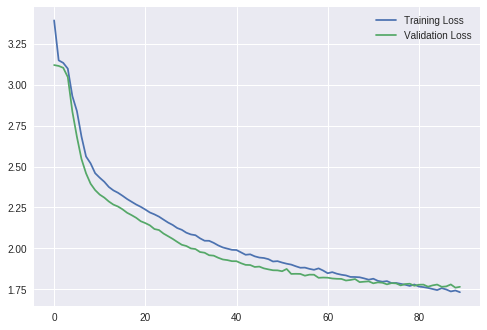

In [56]:
import matplotlib.pyplot as plt

#analysising training and validation loss over the training time
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(["Training Loss","Validation Loss"])
plt.show()

It is clear from the graph that if the model is trained any further it will overfit the training data. Even after trying with all possible hyperparameters this was the best result. This means that 94k characters aren't sufficient to train our model. Introducing more characters, around 10mil, will allow us to increase the size of our hidden layer which will increase the accuracy of our model.

In [0]:
#saving the model
model_name = 'lstm_55_epoch_128_h_50_dp.net'

checkpoint = {'n_hidden': model.n_hidden,
              'n_layers': model.n_layers,
              'state_dict': model.state_dict(),
              'chars_len': model.chars_len}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

In [0]:
import torch.nn.functional as F

def predict(model, char, h=None, top_k=None):
  ''' method to predict next character in the sequence
  
  model: model to be used to predict character
  char: int of current character, i.e input for the model
  h: hidden layer 
  top_k: no. of top k possible characters
  '''

  # tensor inputs
  x = np.array([[char_2_int[char]]])
  x = one_hot_encoding(x, model.chars_len)
  inputs = torch.from_numpy(x).to(device)

  # detach hidden state from history
  h = tuple([each.data for each in h])
  # get the output of the model
  out, h = model(inputs, h)

  # get the character probabilities
  p = F.softmax(out, dim=1).data

  p = p.cpu() # move to cpu

  # get top characters
  if top_k is None:
      top_ch = np.arange(len(model.chars))
  else:
      p, top_ch = p.topk(top_k)
      top_ch = top_ch.numpy().squeeze()

  # select the likely next character with some element of randomness
  p = p.numpy().squeeze()
  char = np.random.choice(top_ch, p=p/p.sum())

  # return the encoded value of the predicted char and the hidden state
  return int_2_char[char], h

In [0]:
def sample(model, size, prime='The', top_k=None):
  """method to sample or generate string fraom predicted characters
  
  model: model used to predict
  size: number of characters to be predicted
  prime: intialising sequence
  top_k: no. of top k possible characters"""
  
  model = model.to(device)
  model.eval() # eval mode

  # First off, run through the prime characters
  chars = [ch for ch in prime]
  h = model.init_hidden(1,device)
  for ch in prime:
      char, h = predict(model, ch, h, top_k=top_k)

  chars.append(char)

  # Now pass in the previous character and get a new one
  for ii in range(size):
      char, h = predict(model, chars[-1], h, top_k=top_k)
      chars.append(char)

  return ''.join(chars)

In [60]:
#testing the model
print(sample(model, 200, prime='You', top_k=2))

You that shall, to the see,
The world to stall to the store and tome,
Then thou the sheer than the worth thee to the well,
To to shall to the will the worth thou thee,
And then my love all store thou the 


While there are meaningfull words in the output, there is substancial lack of structure in the content. This can be improved if the model is trained for longer time on a bigger data. Andrew Karpathy mentions in his post that he trained his model for an hour on Shakespeare's dramas to achieve the result mentioned in his post. <a href="http://karpathy.github.io/2015/05/21/rnn-effectiveness/">Andrew Karpathy's post</a>